# Origin and explanations: 

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [84]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf 

import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

if int(tf.__version__[0]) > 1:    
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
    from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
    from tensorflow.keras import regularizers
else:
    from keras.models import Model, load_model
    from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
    from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
    from keras import regularizers

from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta    
    
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

In [85]:
df = pd.read_csv("data/creditcard.csv")

# Exploration

In [86]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [87]:
df.isnull().values.any()

False

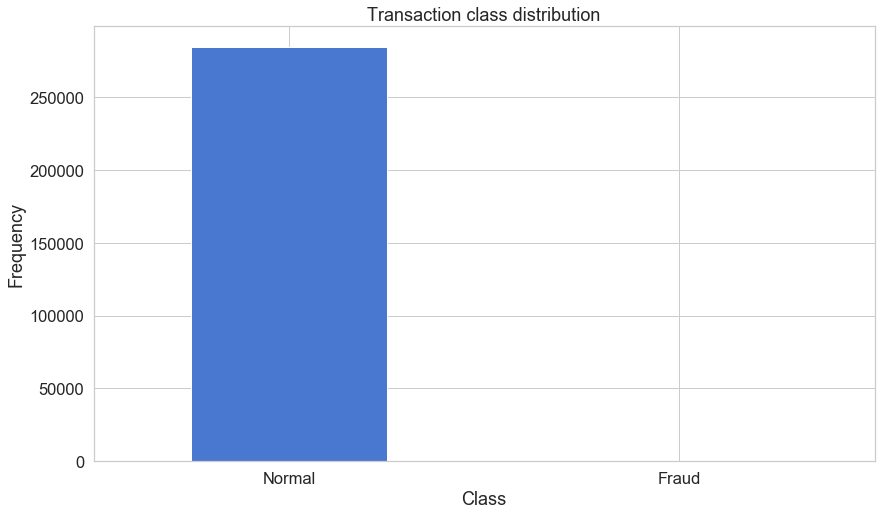

In [88]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [89]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [90]:
frauds.shape

(492, 31)

In [91]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [92]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [93]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

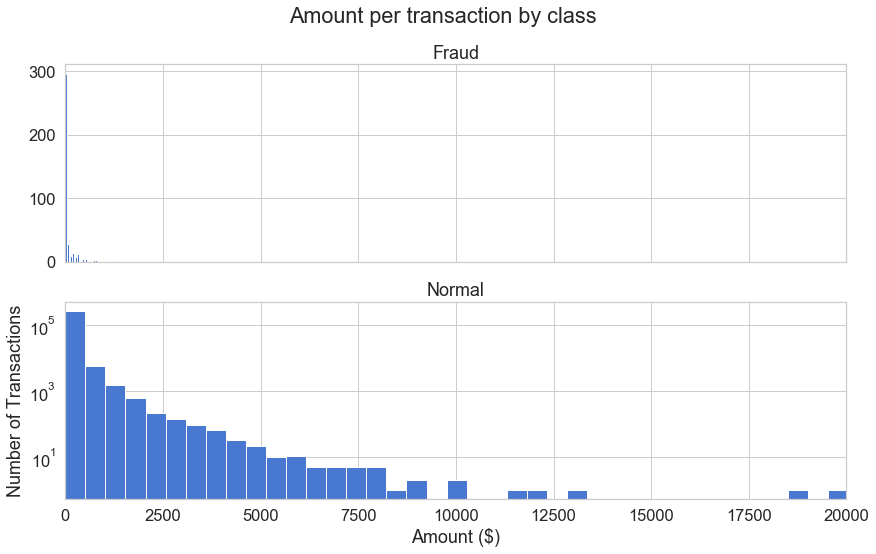

In [94]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

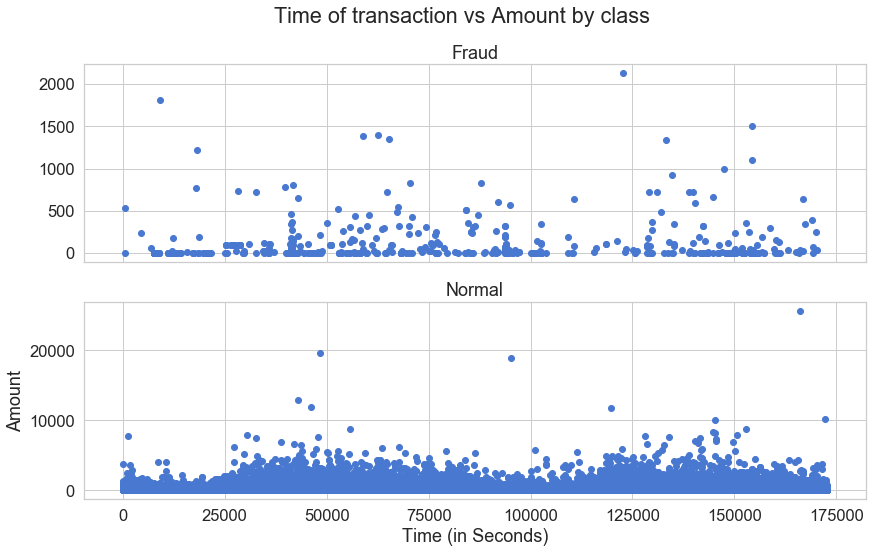

In [95]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Isolation Forest:

In [204]:
data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [205]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED)

y = data['Class'].values
X = data.drop(['Class'],axis=1).values

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_autoencoder = X_train[y_train==0]

In [206]:
X_train.shape

(227846, 29)

In [207]:
X_test.shape

(56961, 29)

In [208]:
# y = data['Class']
# X = data.drop(['Class'],axis=1)
# X_for_autoencoder_training = data[data.Class == 0].drop(['Class'],axis=1)

# X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# X_train = X_train[X_train.Class == 0]
# X_train = X_train.drop(['Class'], axis=1)

# y_test = X_test['Class']
# X_test = X_test.drop(['Class'], axis=1)

# X_train = X_train.values
# X_test = X_test.values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# # X_train = X_train.values
# # X_test = X_test.values

In [209]:
contamination = y_train.sum()/len(y_train)

In [210]:
contamination

0.0017292381696408978

In [211]:
# Isolation Forest ----

# training the model
clf = IsolationForest(contamination=contamination, random_state=RANDOM_SEED, n_jobs=-1)
clf.fit(X_train)

# predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
# y_pred_outliers = clf.predict(X_outliers)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [212]:
set(list(y_pred_test))

{-1, 1}

In [213]:
# isolation forest sets anomalies to -1 and normal observations to 1
# original dataset is 0 for normal observations and 1 for fraud

In [214]:
y_pred_test = [0 if x==1 else 1 for x in y_pred_test]

In [215]:
set(list(y_pred_test))

{0, 1}

In [216]:
print((np.array(y_pred_test)==0).sum())

56902


In [217]:
print((np.array(y_pred_test)==1).sum())

59


In [218]:
f1_score(y_test, y_pred_test)  

0.0

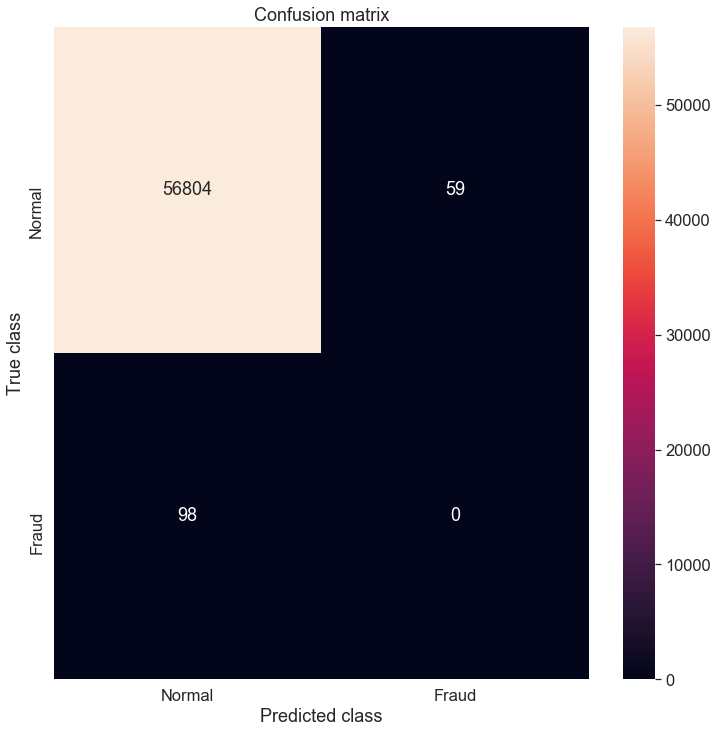

In [219]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Autoencoder:

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [220]:
# data = df.drop(['Time'], axis=1)

# data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [221]:
# X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
# X_train = X_train[X_train.Class == 0]
# X_train = X_train.drop(['Class'], axis=1)

# y_test = X_test['Class']
# X_test = X_test.drop(['Class'], axis=1)

# X_train = X_train.values
# X_test = X_test.values

In [222]:
X_train_autoencoder.shape

(227452, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [293]:
input_dim = X_train_autoencoder.shape[1]
encoding_dim = 160
dropout_rate = 0.1
l2_amount = 0.0

In [294]:
encoding_dim / 8

20.0

In [295]:
(encoding_dim / 8) / input_dim

0.6896551724137931

In [298]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activity_regularizer=regularizers.l2(l2_amount))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Dropout(dropout_rate)(encoder)
encoder = Dense(int(encoding_dim / 2), activity_regularizer=regularizers.l2(l2_amount))(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Dropout(dropout_rate)(encoder)
# encoder = Dense(int(encoding_dim / 4), activity_regularizer=regularizers.l2(l2_amount))(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Activation('relu')(encoder)
# encoder = Dropout(dropout_rate)(encoder)
# encoder = Dense(int(encoding_dim / 6), activity_regularizer=regularizers.l2(l2_amount))(encoder)
# encoder = BatchNormalization()(encoder)
# encoder = Activation('relu')(encoder)
# encoder = Dropout(dropout_rate)(encoder)
encoder = Dense(int(encoding_dim / 8), activity_regularizer=regularizers.l2(l2_amount))(encoder)

encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Dropout(dropout_rate)(encoder)

decoder = Dense(int(encoding_dim / 8), activity_regularizer=regularizers.l2(l2_amount))(encoder)
# decoder = BatchNormalization()(decoder)
# decoder = Activation('relu')(decoder)
# decoder = Dropout(dropout_rate)(decoder)
# decoder = Dense(int(encoding_dim / 6), activity_regularizer=regularizers.l2(l2_amount))(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = Activation('relu')(decoder)
# decoder = Dropout(dropout_rate)(decoder)
# decoder = Dense(int(encoding_dim / 4), activity_regularizer=regularizers.l2(l2_amount))(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
decoder = Dropout(dropout_rate)(decoder)
decoder = Dense(int(encoding_dim / 2), activity_regularizer=regularizers.l2(l2_amount))(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
# decoder = Dropout(dropout_rate)(decoder)
decoder = Dense(input_dim)(decoder)
# decoder = Activation('relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [299]:
nb_epoch = 100
batch_size = 32
# optimizer = RMSprop(learning_rate=0.001, rho=0.9)
optimizer = Adadelta(learning_rate=1.0, rho=0.95)

autoencoder.compile(optimizer=optimizer, 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

mc_callback = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tb_callback = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es_callback = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=5, 
                            verbose=2, 
                            mode='auto', 
                            baseline=None, 
                            restore_best_weights=True)


history = autoencoder.fit(X_train_autoencoder, X_train_autoencoder,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[mc_callback, tb_callback, es_callback]).history

Train on 181961 samples, validate on 45491 samples
Epoch 1/100
181961/181961 [==============================] - 21s 113us/sample - loss: 0.5180 - accuracy: 0.4763 - val_loss: 0.3401 - val_accuracy: 0.7154
Epoch 2/100
181961/181961 [==============================] - 18s 101us/sample - loss: 0.4167 - accuracy: 0.5146 - val_loss: 0.3294 - val_accuracy: 0.7247
Epoch 3/100
181961/181961 [==============================] - 18s 101us/sample - loss: 0.3923 - accuracy: 0.5244 - val_loss: 0.3048 - val_accuracy: 0.7391
Epoch 4/100
181961/181961 [==============================] - 18s 101us/sample - loss: 0.3776 - accuracy: 0.5317 - val_loss: 0.2756 - val_accuracy: 0.7406
Epoch 5/100
181961/181961 [==============================] - 18s 101us/sample - loss: 0.3633 - accuracy: 0.5385 - val_loss: 0.2673 - val_accuracy: 0.7461
Epoch 6/100
181961/181961 [==============================] - 18s 101us/sample - loss: 0.3546 - accuracy: 0.5412 - val_loss: 0.2606 - val_accuracy: 0.7432
Epoch 7/100
181961/181961

In [300]:
# .396 without final relu
# .710 with final relu (probably some values are supposed to be negative)
# .550 removing final batch norm 
# .613 with 0.1 dropout
# .212 with fewer layers
# .157 Adam --> RMSprop (both default)
# .1002 Adadelta with defaults

In [301]:
# autoencoder = load_model('model.h5')

# Evaluation

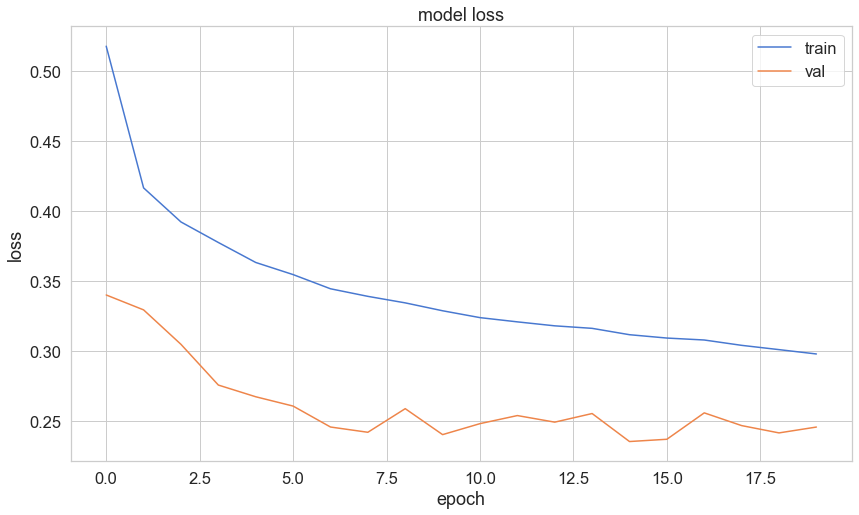

In [304]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [305]:
predictions = autoencoder.predict(X_test)

In [306]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [307]:
error_df.describe()

,reconstruction_error,true_class
count,56961.000000,56961.000000
mean,0.217444,0.001720
std,1.817094,0.041443
min,0.021918,0.000000
25%,0.083369,0.000000
50%,0.126417,0.000000
75%,0.203865,0.000000
max,396.755412,1.000000


## Reconstruction error without fraud

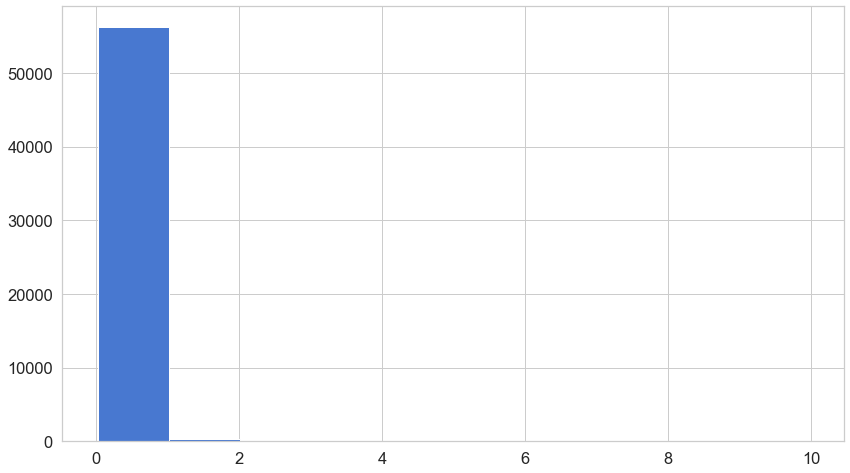

In [308]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

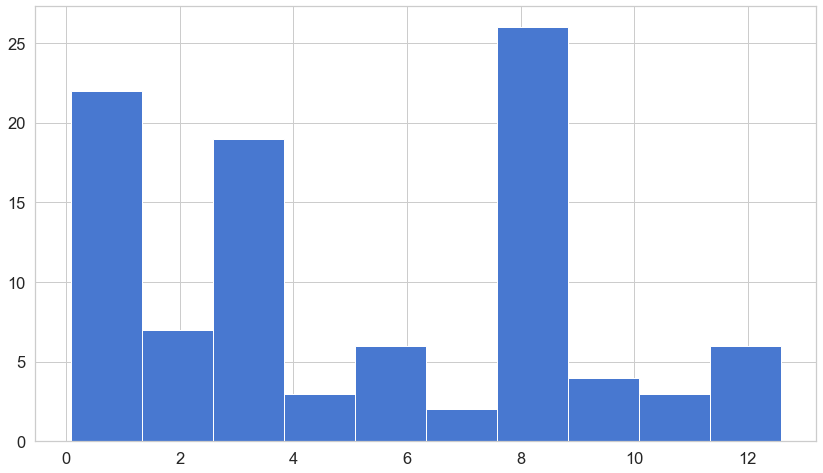

In [309]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

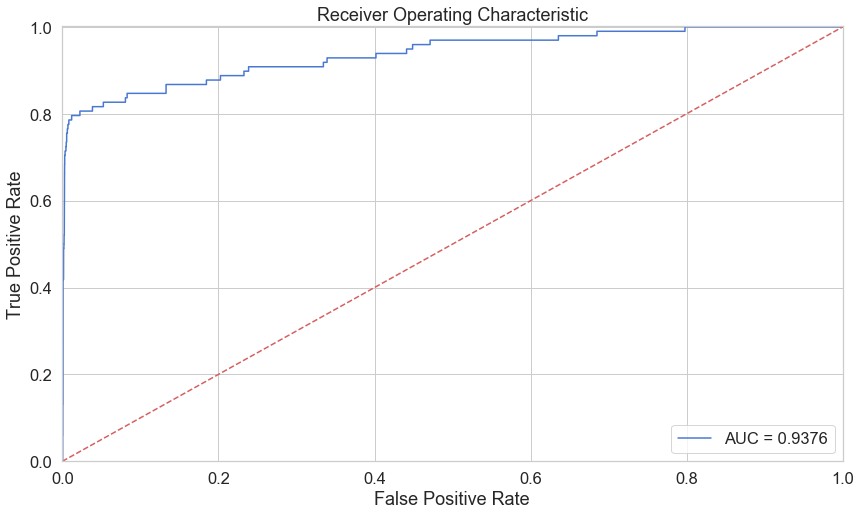

In [310]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

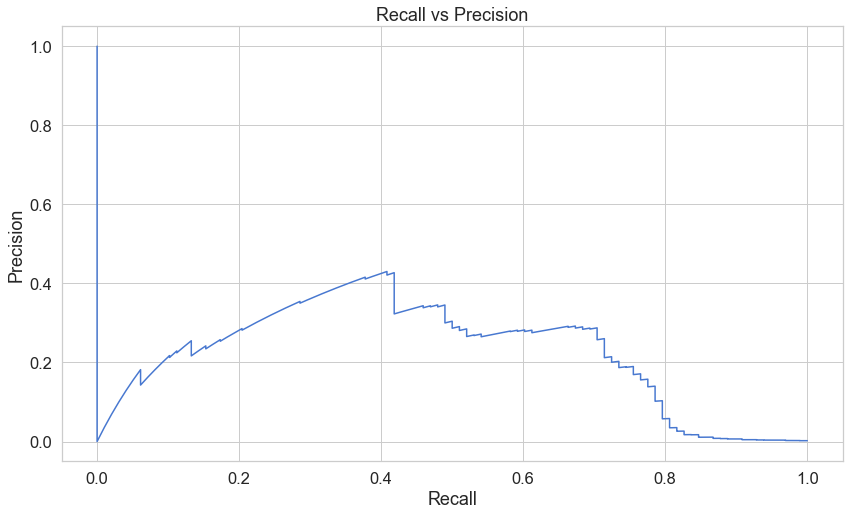

In [311]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

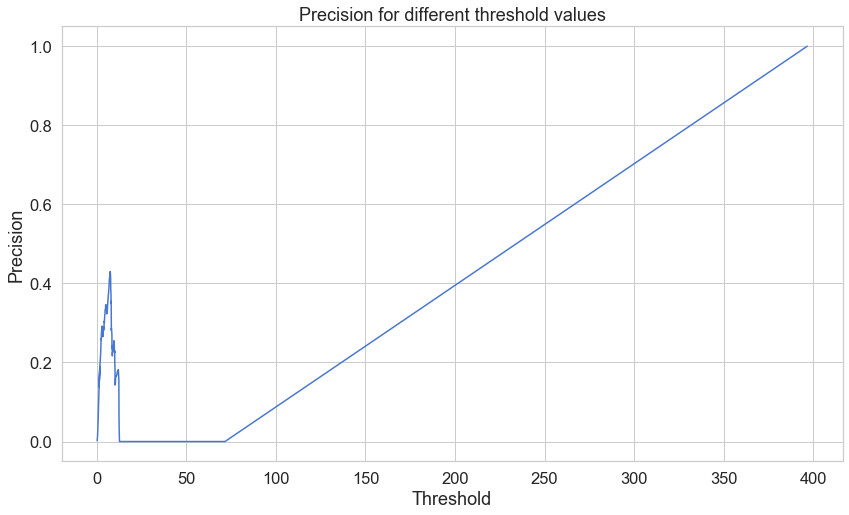

In [312]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

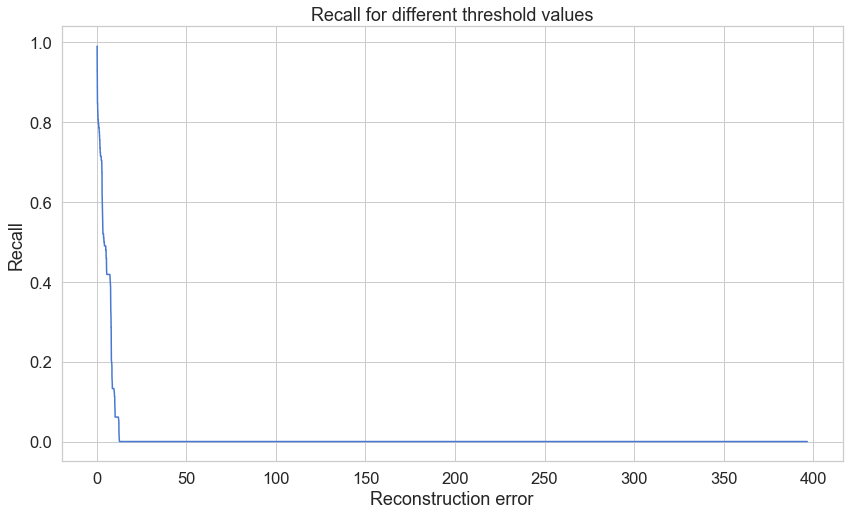

In [313]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# MLP with reconstruction error as a feature

In [314]:
X_train_predictions = autoencoder.predict(X_train)

In [315]:
X_train_encoder_mse = np.mean(np.power(X_train - X_train_predictions, 2), axis=1)

In [316]:
X_train.shape

(227846, 29)

In [317]:
X_train_encoder_mse.shape

(227846,)

In [318]:
X_train_augmented = np.concatenate((X_train, X_train_encoder_mse.reshape((-1,1))), axis=1)

In [319]:
X_train_augmented

array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.02105305,
         0.24496426,  0.07594071],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.01472417,
        -0.34247454,  0.02350458],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.05975184,
         1.16068593,  0.21621003],
       ...,
       [-1.24615005,  0.86306391,  0.47869033, ...,  0.07726675,
        -0.12933657,  0.78850701],
       [-0.11060264,  0.85805725, -1.27380033, ...,  0.134559  ,
        -0.31328851,  0.34613314],
       [-0.41332759,  1.30124116,  1.45116153, ...,  0.13441132,
        -0.2322473 ,  0.18878475]])

In [320]:
input_dim = X_train_augmented.shape[1]
initial_dim = 1000
dropout_rate = 0.3
l2_amount = 10e-5

In [321]:
input_layer = Input(shape=(input_dim, ))

x = Dense(initial_dim, activity_regularizer=regularizers.l2(l2_amount))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)

for step_size in [2, .5, 2]:
    x = Dense(int(encoding_dim / step_size))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

x = Dense(1)(x)    
output = Activation('sigmoid')(x)

mlp_classifier = Model(inputs=input_layer, outputs=output)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [322]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [323]:
nb_epoch = 100
batch_size = 32
# optimizer = RMSprop(learning_rate=0.001, rho=0.9)
optimizer = Adadelta(learning_rate=1.0, rho=0.95)

mlp_classifier.compile(optimizer=optimizer, 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

mc_callback = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tb_callback = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es_callback = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=5, 
                            verbose=2, 
                            mode='auto', 
                            baseline=None, 
                            restore_best_weights=True)


history = mlp_classifier.fit(X_train_augmented, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    class_weight=class_weights,
                    callbacks=[mc_callback, tb_callback, es_callback]).history

Train on 205061 samples, validate on 22785 samples
Epoch 1/100
205061/205061 [==============================] - 32s 156us/sample - loss: 0.0149 - accuracy: 0.9981 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 2/100
205061/205061 [==============================] - 29s 143us/sample - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/100
205061/205061 [==============================] - 29s 142us/sample - loss: 0.0078 - accuracy: 0.9991 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 4/100
205061/205061 [==============================] - 29s 142us/sample - loss: 0.0078 - accuracy: 0.9991 - val_loss: 8.4753e-04 - val_accuracy: 1.0000
Epoch 5/100
205061/205061 [==============================] - 29s 142us/sample - loss: 0.0076 - accuracy: 0.9991 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 6/100
205061/205061 [==============================] - 29s 143us/sample - loss: 0.0070 - accuracy: 0.9992 - val_loss: 6.8050e-04 - val_accuracy: 1.0000
Epoch 7/100
20506

In [324]:
X_test_predictions = autoencoder.predict(X_test)

In [325]:
X_test_encoder_mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

In [326]:
X_test_augmented = np.concatenate((X_test, X_test_encoder_mse.reshape((-1,1))), axis=1)

In [332]:
y_pred_probs_mlp = mlp_classifier.predict(X_test_augmented)

In [369]:
threshold = 0.001

In [370]:
y_pred_mlp = [1 if e > threshold else 0 for e in y_pred_probs_mlp]

In [371]:
f1_score(y_test, y_pred_mlp)  

0.6972477064220183

## Metric plots

In [375]:
def plot_roc_auc(true, pred):
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

In [396]:
def plot_precision_recall(true, pred):
    precision, recall, th = precision_recall_curve(true, pred)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [410]:
def plot_precision_threshold(true, pred):
    precision, recall, th = precision_recall_curve(true, pred)
    plt.plot(th, precision[1:], 'b', color='blue', label='Precision')
    plt.plot(th, recall[1:], 'b', color='orange', label='Recall')
    plt.title('Precision and Recall for different threshold values')
    plt.xlabel('Threshold')
#     plt.ylabel('Precision, Recall')
    plt.legend()
    plt.show()

In [411]:
def plot_precision(true, pred):
    precision, recall, th = precision_recall_curve(true, pred)
    plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    plt.title('Precision for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.show()

In [412]:
def plot_recall(true, pred):
    precision, recall, th = precision_recall_curve(true, pred)
    plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
    plt.title('Recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.show()

In [413]:
def plot_conf_matrix(true, pred):
    conf_matrix = confusion_matrix(true, pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

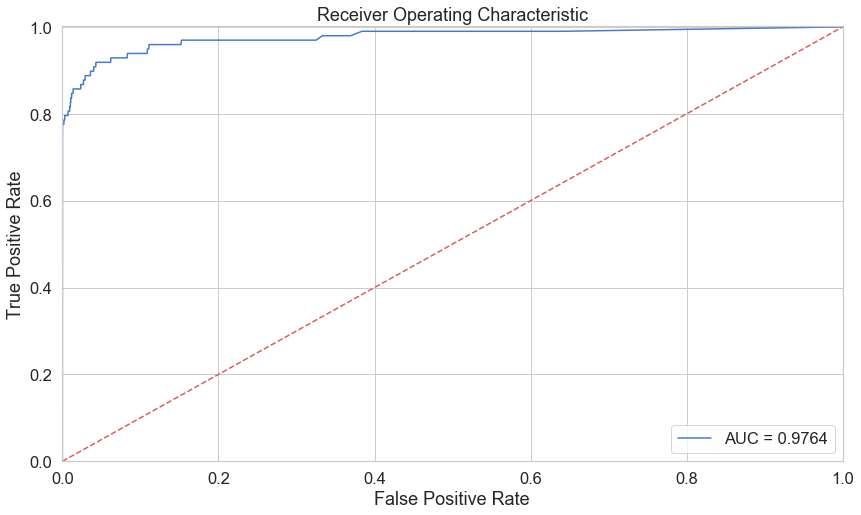

In [414]:
plot_roc_auc(y_test, y_pred_probs_mlp)

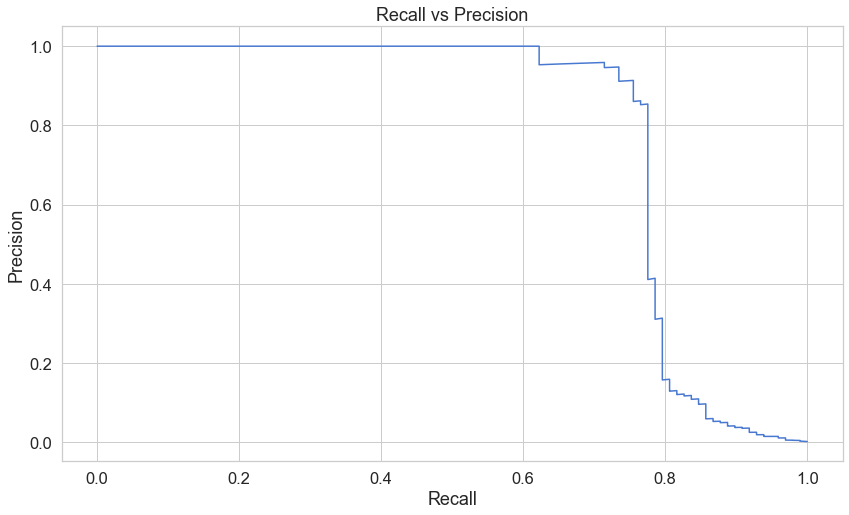

In [415]:
plot_precision_recall(y_test, y_pred_probs_mlp)

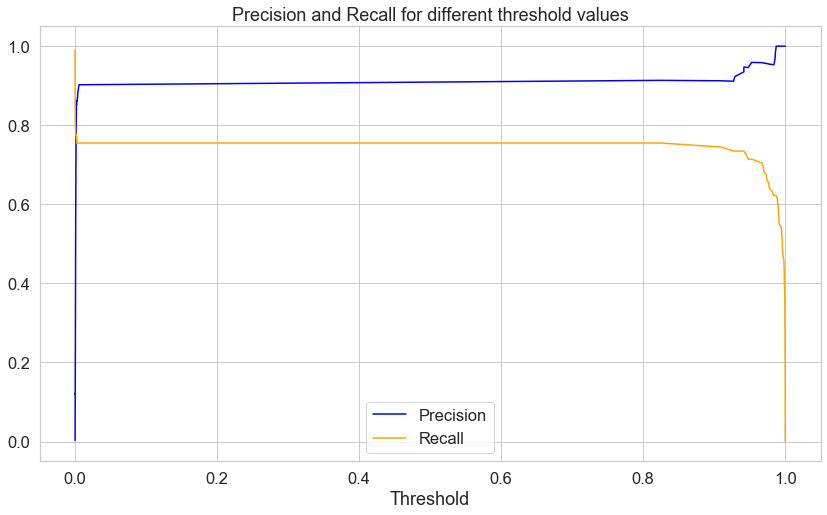

In [416]:
plot_precision_threshold(y_test, y_pred_probs_mlp)

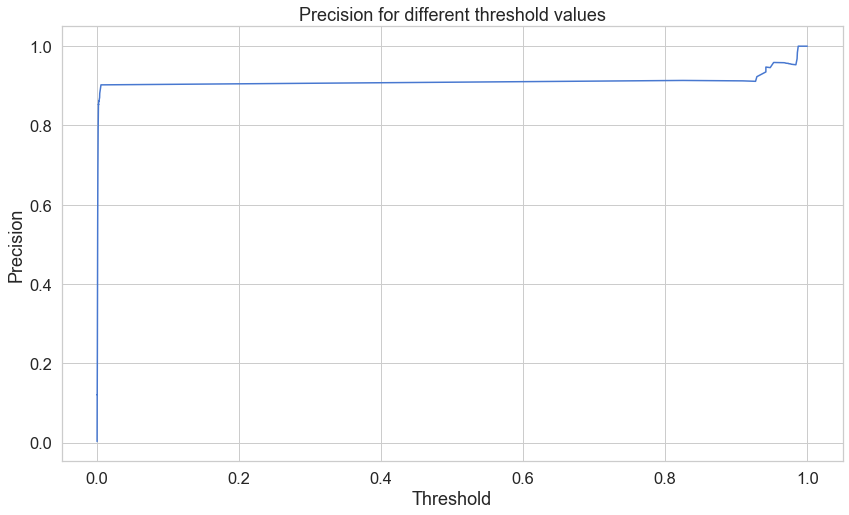

In [417]:
plot_precision(y_test, y_pred_probs_mlp)

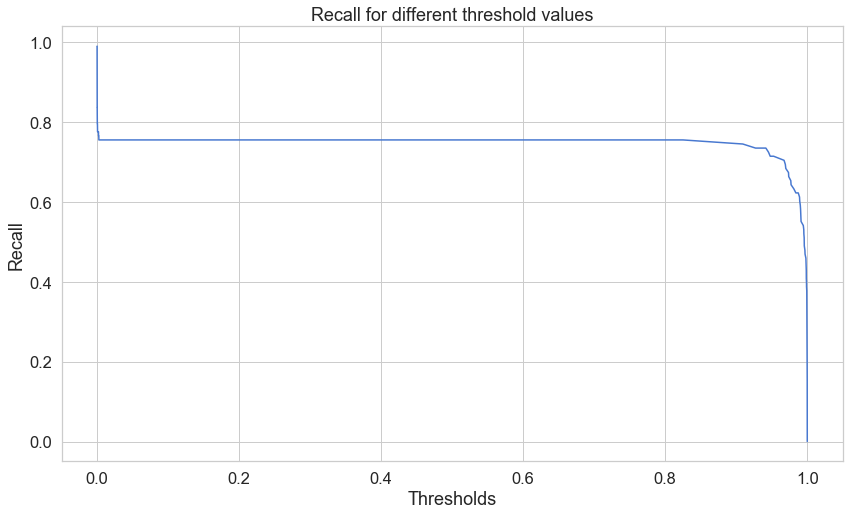

In [395]:
plot_recall(y_test, y_pred_probs_mlp)

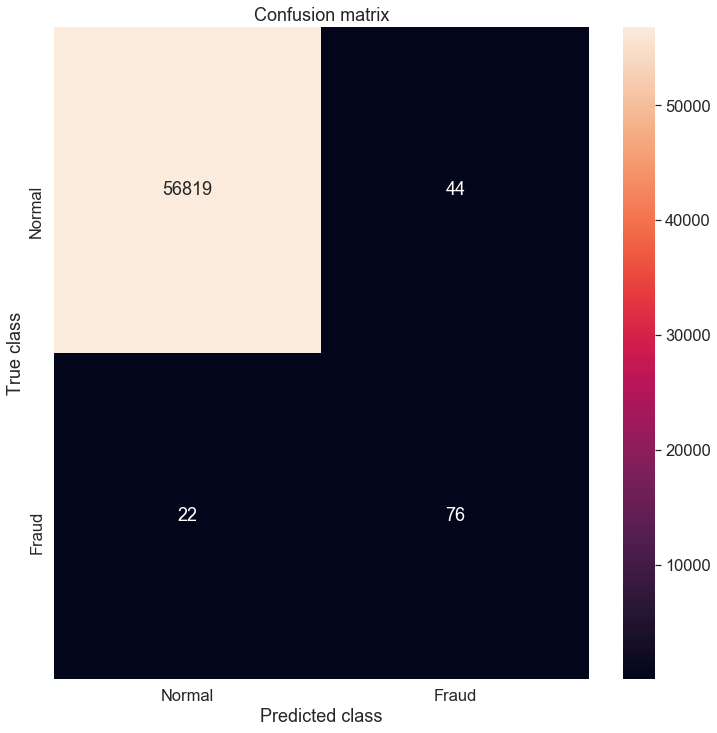

In [393]:
plot_conf_matrix(y_test, y_pred_mlp)

## Prediction


In [ ]:
threshold = 2.9

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

In [ ]:
f1_score(error_df.true_class, y_pred)  

In [ ]:
best_f1 = 1.
thresholds = range(1,600)
for threshold in thresholds:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    curr_f1 = f1_score(error_df.true_class, y_pred)  
    # if no predicted samples, f1 is set to 0.0
    if curr_f1 > best_f1 and curr_f1 > 0.0:
        best_f1 = curr_f1
        best_threshold = threshold

In [ ]:
best_threshold

In [ ]:
best_f1

In [ ]:
y_pred = [1 if e > best_threshold else 0 for e in error_df.reconstruction_error.values]

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(best_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# F-Beta

In [ ]:
best_fbeta = 1.
thresholds = range(1,6000)
for threshold in thresholds:
    y_pred = [1 if e*10 > threshold else 0 for e in error_df.reconstruction_error.values]
    curr_fbeta = fbeta_score(error_df.true_class, y_pred, beta=1.5)  
    # if no predicted samples, fbeta is set to 0.0
    if 0.0 < curr_fbeta > best_fbeta:
        best_fbeta = curr_fbeta
        best_threshold = threshold

In [ ]:
best_threshold = best_threshold / 10
best_threshold

In [ ]:
best_fbeta

In [ ]:
y_pred = [1 if e > best_threshold else 0 for e in error_df.reconstruction_error.values]

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(best_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)